# Lecture 8 GA2048: Derivatives Hedging

## Topics

* Review of Curve Bootstrapping
* Derivatives Hedging 
* Risk transformation
* Hedge Optimization
* Implied Volatility Smile and Variance Swaps

$\renewcommand{bt}[1]{\tilde{\boldsymbol #1}}$
$\renewcommand{bs}{\boldsymbol} \renewcommand{var}{\text{var}} \renewcommand{std}{\text{std}} \renewcommand{cov}{\text{cov}}$
$\newcommand{\eps}{\varepsilon} \renewcommand{\s}{\sigma} \newcommand{\E}{\mathbb{E}} \newcommand{\P}{\mathbb{P}}$
$\newcommand{\F}{\mathcal{F}} \newcommand{\half}{\frac{1}{2}} \newcommand{\R}{\mathbb{R}} \newcommand{\Z}{\mathbb{Z}} $
$\newcommand{\w} {\omega} \newcommand{\l} {\ell} \newcommand{\lbd} {\lambda} \renewcommand{\S}{\Sigma}$ 
$\newcommand{\a} {\alpha} $
$\newcommand{\Z} {\mathbb{Z}} $

### Derivatives, Deltas and Hedging

Derivatives pricing and hedging theory is covered in depth in courses:
- MATH-GA.2792 Continuous Time Finance
- MATH-GA.2793 Dynamic Asset Pricing
- MATH-GA.2045 Nonlinear Problems In Finance
- MATH-GA.2801 Advanced Topics In Equity Derivatives
- MATH-GA.2798 Interest Rate & Fx Models

Some references:
* [Fundamentals and Advanced Techniques in Derivatives Hedging (by Bruno Bouchard \& J.F. Chassagneux)](https://www.springer.com/gp/book/9783319389882)
* [Stochastic Volatility Modeling (Lorenzo Bergomi)](https://www.amazon.com/Stochastic-Volatility-Modeling-Financial-Mathematics/dp/1482244063)

In [1]:
import os
import sys

cwd = os.getcwd()
sys.path.append(cwd[:-15] + "\\GA2048\\lib\\")
sys.path.append(cwd[:-15] + "\\GA2048\\img\\")
#sys.path.append(cwd[:-15] + "\\GA2048\\data\\")

import pricing, interpolation_curve, fmt

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm

from copy import copy

# Curve Building in Finance


## Curve building fundamentals

* Inputs: prices of benchmark instruments of the same risk factor, at different maturities
* Outputs: a single curve for the underlying factor that explains all observed prices to adequate precision.
* Curve building is a fundamental problem in Finance, it can become extremely complicated

## Common types of curves
* Term structure of implied volatility or Total Variance
* Interest rate: OIS, Libor 3M/6M etc,
* CDS (credit default swap)
* Commodity
* FX
* Inflation

<div class="alert alert-block alert-warning">
Note: in real life, details on compounding, day count fractions, etc. need to be considered. For simplicity of the exposition, these details are omitted.
</div>

## Curve terminology


$B(t) = B(0, t)$ is the price of risk free zero coupon bond maturing at $t$.

* Zero rate (or spot rate, yield, internal rate of return): 

$$r(t) = -\frac{1}{t}\log(B(t)) \iff B(t) = e^{-r(t) t} $$

* Forward rate: 

$$f(t) = -\frac{1}{B(t)}\frac{d B(t)}{d t} \iff B(t) = e^{-\int_{0}^t f(s) ds} $$

* Swap rate (continuous coupon): 

$$s(t) = \frac{1 - B(t)}{\int_0^t B(s) ds} \iff s(t) \int_0^t B(s) ds + B(t) = 1 $$ 

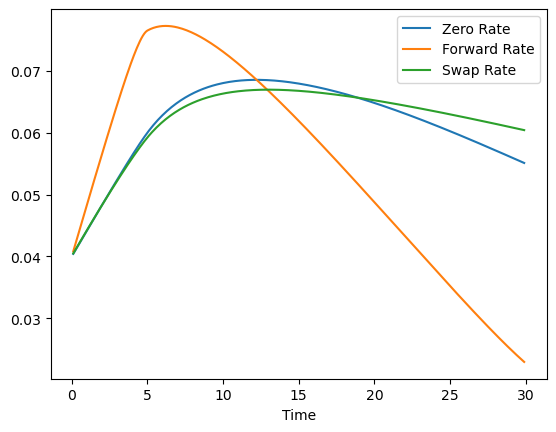

In [2]:
dt = .1
t = np.arange(dt, 30, dt)

tn = np.array([0, 5, 30])
rn = np.array([.04, .06, .055])

zero_rate = interpolation_curve.RationalTension(2.)
zero_rate.fit(tn, rn)

fwd_rate = zero_rate(t) + t*zero_rate.derivate(t)
b = np.exp(-t*zero_rate(t))
intb = np.cumsum(b*dt)
swap_rate = (1-b)/intb

plt.plot(t, zero_rate(t));
plt.plot(t, fwd_rate)
plt.plot(t, swap_rate)

plt.legend(['Zero Rate', 'Forward Rate', 'Swap Rate'], loc='best');
plt.xlabel('Time');

# Reminder on IR Swaps Pricing

## Present Value = Risk-Neutral Discounted Cash Flow

### Discount Factor and ZCB

Let's note $D(t) = D(0,t)$ the (stochastic) discount factor (e.g. the inverse quantity resulting from investing one unit of currency in a money market account/mechanism). In a short rate notation, we would have $D(t) = e^{-\int_0^t r_u} du$, but do not impose such restriction here. In particular and ignoring credit-risk consideration, one has that the PV of a zero-coupon is $B(t) = E(D(t))$ where $E$ is (or one amongst infinitely many) the risk-neutral (pricing) measure.

### IR Swaps at time $t=0$
An IR Swaps exchange a fixed-rate leg against a floating leg.


#### Fixed Leg PV
The fixed-rate leg pays at time $T_1, ..., T_N$ cash flow of the form $S(T_M) \delta_{T_j, T_{j-1}}$ where:
* $S(T_M)$ is a (deterministic) constant interest rate. It is usually the result of market mechanism (supply and demand, market microstructure, price discovery processes, etc.) and by convention is the quantity such that the IR swap is fair for both counterpart entering the swap. It means, there is nothing to pay (other that the initial margin and other regularity capital charges paid to the exchange).
* $\delta_{T_{j-1}, T_j}$ is the year fraction between $T_{j-1}$ and $T_j$.

The resulting PV is given by
$$ PV_{fixed} = E\left(\sum_{i=1}^{M} S(T_M) D(T_j) \delta_{T_{j-1}, T_j} \right) = S(T_M) \sum_{i=1}^{M} B(T_j) \delta_{T_{j-1}, T_j} = S(T_M) A(T_M) $$

When clear from the context, we may simply write $S(T_M) = S$. The term $A(T_M)$ is usually refered as to the annuity (factor) or the "PV01", because the expression of the fixed leg PV seems to yield $\partial_S PV_{fixed} = A(T_M)$. This expression is however only an approximation as if the discount curve is computed so as to be consistent with a term structure of $S(T_i)$, then the annuity factor depends on $S(T_1),...,S(T_M)$ as well, and it would be more precise to write $\partial_S PV_{fixed} = A(T_M) + S(T_M) \partial_S A(T_M)$. The latter quantity is often small in practice.


#### Floating Leg PV
The floating leg pays at time $t_1, ..., t_N$ cash flow of the form $R_{t_i} \Delta_{t_{i-1}, t_i}$ where:
* $R_{t_i}$ is a (stochastic) interest rate. It can have fixed at time $t_i$ (e.g. compounded SOFR rate) or before (e.g. at time $t_{i-1}$ as the now old fashioned Libor). 
* $\Delta_{t_{i-1}, t_i}$ is the year fraction between $t_{i-1}$ and $t_i$, which can (depending on the market) follow a different convention from that of  $\delta(t_{i-1}, t_i)$.


The resulting PV is given by
$$ PV_{floating} =  E\left(\sum_{i=1}^{N} R_{t_i} \Delta_{t_{i-1}, t_i}\right) = \sum_{i=1}^{N} E^{t_i}(R_{t_i}) B(T_i) \Delta_{t_{i-1}, t_i} = \sum_{i=1}^{N} F_{t_i} B(T_i) \Delta_{t_{i-1}, t_i}$$

The quantity $E^{t_i}(R_{t_i}) = F_{t_i}$ (used to be noted $L(t_i)$ in the days of the Libor rate) is the forward rate of $R_{t_i}$ and is the expectation of the (stochastic) floating rate taken under the so-called $t_i$-forward measure.

Under the usual assumption that if one (could!!) invests 1 unit of ccy at time zero in an investment program (e.g. money market) indexed on the rate $R_T$, then at time $T_1$ the investor receives the interest quantity $R_{T_1} \Delta(T_0, T_1)$, so forth until payment of last interest quantity and notional at time $T_M$. As such one has:
$$ 1 = E\left(\sum_{i=1}^{N} R_{t_i} \Delta_{t_{i-1}, t_i}\right) + B(T_M) = \sum_{i=1}^{N} E^{T_i}(R_{t_i}) B(T_i) \Delta_{t_{i-1}, t_i} + B(T_M) \Leftrightarrow \sum_{i=1}^{N} F_{t_i} B(T_i) \Delta_{t_{i-1}, t_i} = 1 - B(T_M)$$

$$ PV_{floating} = \sum_{i=1}^{N} F_{t_i} B(T_i) \Delta_{t_{i-1}, t_i} = 1 - B(T_M)$$

#### IR Swap PV and Fair Swap Rate

Looking for the constant swap rate that gives $PV_{fixed} = PV_{floating}$ gives $S(T_M) = \frac{1 - B(T_M)}{A(T_M)}$ and the PV of the IR swap can be written as
\begin{split}
PV_{IR-swap} &= PV_{fixed} - PV_{floating} \\
&=  S(T_M) \sum_{i=1}^{M} B(T_j) \delta_{T_{j-1}, T_j} - [ 1-B(T_M) ] \\
&= \left( S(T_M) - \frac{1-B(T_M)}{\sum_{i=1}^{M} B(T_j) \delta_{T_{j-1}, T_j}} \right) \sum_{i=1}^{M} B(T_j) \delta_{T_{j-1}, T_j}
\end{split}



<div class="alert alert-block alert-info">
In practice, the two legs do not need to have the same payment schedule, hence the notation with $t_i$ up to $N$ and with $\tau_j$ up to $M$.
    
In this lecture, we will make this simplifying assumption as the same principles apply.
</div>

### Seasoned IR Swaps at time $t\neq0$

Everything is essentially the same, except that the market has moved, while $S_M$ has remained the same, and therefore, there is no reason taht the current PV of the swap under consideration (e.g. traded a year ago) is still at par. In particular, if the consider that $t_1< t \leq t_{n} < T_M$ the PV is then:

\begin{split}
PV_{IR-swap} &=  S(T_M) \sum_{i=n}^{M} B(t, T_j) \delta_{T_{j-1}, T_j} - [ B(t,t_n) -B(t, T_M) ] \\
&=  \left( S(T_M) - \frac{1-B(t, T_M)}{\sum_{i=n}^{M} B(t, T_j) \delta_{T_{j-1}, T_j}} \right) \sum_{i=n}^{M} B(t, T_j) \delta_{T_{j-1}, T_j}\\
& =  (S(T_M) - S(t,T_M) )A(t,T_M) 
\end{split}

where notation to indicate the starting time $t$ has been added for clarity.

### Swap Pricing with a Forward Curve

In the above assumption, the floating rate invovled in the swap instrument (e.g. compound SOFR, old fashioned Libor) was assumed to be a rate at which one could invest. This argument was used to write that $ PV_{floating} =  \sum_{i=1}^{N} F_{t_i} B(T_i) \Delta_{t_{i-1}, t_i} = 1 - B(T_M) $.

Under such assumption, a buy-and-hold strategy of an FRA yields 
$$F_{t_i} \Delta_{t_{i-1}, t_i} = \frac{B(T_i)}{B(T_{i-1})} - 1$$

In reality, the curve used to do the (financial) discounting and the curve used to the represent the forward-rate using the above formula need not be the same; there are actually different and a so-called basis spread between the two curves manifests itself.

To be more precise, let's note $B^F(t)$ the discount factor used to represent the forward rates. Then, using a zero-rate representation (but a forward rate would also work)
$$ B^F(t) = e^{-R(t)^F t} = e^{-[R(t) + sp(t)] t} = B(t) e^{-sp(t) t}$$

From this, the discount curve $B^F$ can be a standalone curve or can be represented from a base curve with a spread condition/assumption.

### Remark on Curve Interpolation and Hedging
<div class="alert alert-block alert-warning">
Curve Interpolation implicitly assumes that a zero-coupon bond can be "stripped" from market instruments (e.g. money market, FRA, Futures, Swaps), that is, a perfect replication can be done with static (i.e. buy and hold) replication strategy.
    
**This is of course not the case in practice**   
</div>

# General Principle of Curve Bootstrapping

Curve bootstrapping does not refer to a stastical method of adding artificial data points to a limited data sample.

Curve boostrapping is a sequential (sometimes also iterative) algorithm which aims at finding the pricing curve(s) (e.g. discounting curve(s), survival probabilities, etc.) such that a set of instruments of reference (e.g. IR swap, Futures, Zero-Coupon bonds, CDS, etc.) are priced.

Most of these instruments have a \$0 (or standardized) PV at inception and therefore, "pricing at market" means taht when pricing these instruments with market quotes, their PV is indeed (very close to) zero.


### General Algorithm:
* There is a term structure of market instrument with obsvered prices $p_i^{mkt}$ for $i=1,...,N$ and corresponding to expiries $t_i$.
* Market prices can be represented with one (or more) discount curve, i.e. a function $b(t)$ satisfying some economical properties, namely $p(t) = P(b(t))$
* We represent the function $b(t)$ either directly, or via another variable, which is also a function $b(t) = F(r(t))$. 
* From some unitial guess value $r_i^{(0)}$, the state variable are interpolated using a spline method, yielding a function $r_0(t)$ such that $r_0(t_i) = r_i^{(0)}$.
* Corresponding prices generally do not match the market: $p^{(0)}(t_i) = P(F(r_0(t_i))) \neq p_i^{mkt}$ since the initial guesses $r_i^{(0)}$ may not be the correct solution.
* Note that theoretical prices for $t \leq t_i$ are only affected by $r(t)$ for $t\leq t_i$.
* Then sequentially:
    - solve $r_1^{(0)} \to r_1^{(1)}$ such that the first theorical price matches market price: $p^{(1)}(t_1) = P(F(r_1(t_1))) = p_1^{mkt} $
    - repeat for all other knots $r_k^{(0)} \to r_k^{(1)}$ such that $p^{(1)}(t_k) = P(F(r_1(t_k))) = p_k^{mkt} $
    - Because changing a subsequent knots $r_k^{(0)}$ will affect prices for $t_j < t_k$, previously matched market prices may not be matched anymore. The discrepancies are expected (hoped!) to be small enough for the next step.
    - Repeat a few times, hoping that the fixed-point the procedure will converge to the desired fixed-point.


### In reality, life is a bit more complex:
* Instruments may overlap and have a complicated coupon structures (there are FRA, fed-fund swaps, SOFR Futures, SOFR swaps...) for various expiry and their corresponding schedule may be perfectly aligned (weekend/holiday effects, etc.)
* As such, than one instruments (and therefore corresponding prices) affected by just one knots.

### Main ingredients:
* (Tension) Spline interpolation
* (Sequential) root finding
* Fixed-point method

<div class="alert alert-block alert-info">
Note that in principle, a global minimization could be used: finding the knots $r_i$ such that the spline passing through the $r_i$, that can be noted $r(t) = r(t, r_1, r_2,...,r_N) = r(t, (r_k))$ solves $\min_{r_i}\sum_{k=1}^N w_k[p_k^{mkt} - P(F(r(t, (r_k))))]^2$. This approach is often too slow, not always accurate and yield poor risks stability/accuracy.
</div>

# Zero Coupon Bond Curve Bootstrapping

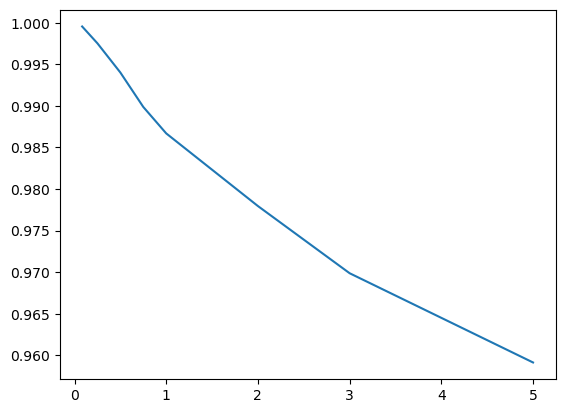

In [3]:
# Pricing of Zero-Coupon Bonds
zcb_maturities = [1./12, 0.25, 0.5, 0.75, 1., 2., 3., 5.]
zcbs = [pricing.ZeroCouponBond(maturity = T) for T in zcb_maturities]

# Pricing is done from a discounting-curve
fwd_rate =  [.01, .012, .017, .015, .011, .009, .007, .005]

fwd_curve = interpolation_curve.RationalTension(0.)
fwd_curve.fit(zcb_maturities, fwd_rate)

#fwd_curve = CubicSpline(zcb_maturities, fwd_rate, bc_type='natural')
discount_curve = pricing.DiscountCurve.fwd2disc(fwd_curve)

zcb_prices = [zcb.pv(discount_curve) for zcb in zcbs]

plt.plot(zcb_maturities, zcb_prices)

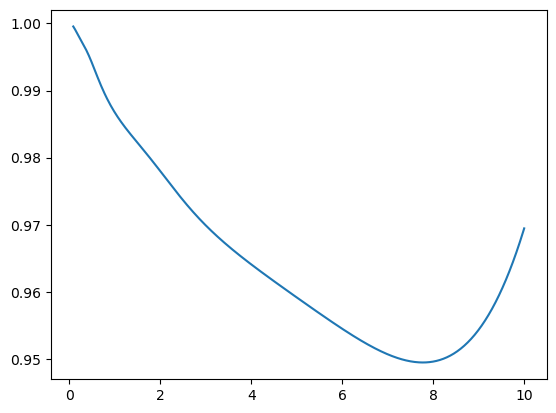

In [4]:
# issue with long term extrapolation
T = 10
t_range = np.linspace(1/12., T, T*52)
plt.plot(t_range, [(pricing.ZeroCouponBond(t)).pv(discount_curve) for t in t_range])

Now let's say we do not know in advance the curve used to price the zero coupon bonds and want to find a curve that prices these zero coupon bond from their prices.

In [5]:
# Bootstrap from zero-rate using piecewise linear
pwlin_zero_rate_curve = interpolation_curve.PiecewiseLinear()
pwlin_zero_rate_curve.fit(zcb_maturities, [(-1/T)*np.log(zc_price) for (T, zc_price) in zip(zcb_maturities, zcb_prices)])
pwlin_zero_rate_curve.insert(0, 0)

bootstrapped_curve = pricing.bootstrap_from_inst_pv({inst: pv for (inst, pv) in zip(zcbs, zcb_prices)}, 
                                             pwlin_zero_rate_curve)


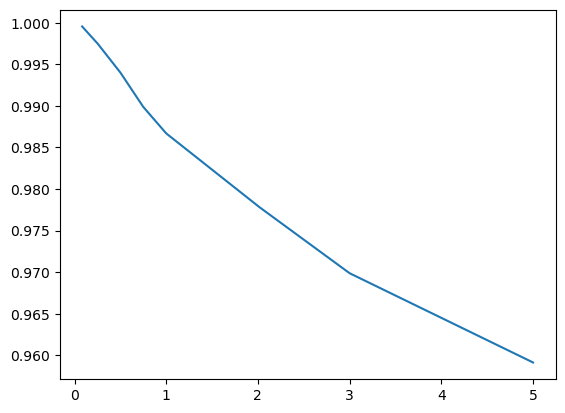

In [6]:
T=5
t_range = np.linspace(1/12., T, T*52)
plt.plot(t_range, [(pricing.ZeroCouponBond(t)).pv(bootstrapped_curve) for t in t_range])

# CDS Curve Bootstrapping

## Introduction to CDS

| No Default | With Default |
| :----: | :-----: |
| <img src="cds1.png"> | <img src="cds2.png"> |

CDS is an insurance against a reference entity's default risk

* protection buyer: makes quarterly payments of notional$\times$spread$\times$daycount.
* protection seller: pays the default loss of notional$\times$(1-rec) when the reference entity defaults before CDS maturity.

## Reminder on Basic Credit Modeling and CDS Pricing

We note $\tau$ the instant of default of a credit entity of reference.

The survival probability is noted $p(t) = \mathbb{P}(\tau > t)$, i.e. the probability that default occurs after time $t$.

A simple representation of such function is similar to what is done for a discount factor, namely we write
$$ p(t) = e^{-\int_0^t h(u) du} \Leftrightarrow \mathbb{P}(\tau \leq t) = 1 - e^{-\int_0^t h(u) du}$$

where the function $h$ is refered to as the **hazard rate**.

Under the assumption that the credit event and IR are independent, than a fixed of floating cash flow subject to default having not happened yet is given by:
$$ E\left(c 1_{\tau > t} e^{-\int_0^t r_u du} \right) = E^{\mathbb{Q}_t}(c) p(t) B(t) $$

If the cash flow is not contingent to default happening (e.g. recovery leg) before some maturity $T$, then (for $0=t_0<...<t_N=T$)
\begin{split}
E\left( c 1_{\tau < T} e^{-\int_0^{\tau} r_u du} \right) & = c \sum_{i=0}^{N-1} E\left( 1_{t_i < \tau \leq t_{i+1}} e^{-\int_0^{\tau} r_u du} \right) \\
& = c \sum_{i=0}^{N-1} E\left( 1_{t_i < \tau \leq t_{i+1}} e^{-\int_0^{t_i} r_u du} \right) + R_N \\
& = c \sum_{i=0}^{N-1} B(T_i) [\P(\tau \leq t_{i+1}) - \P(\tau\leq t_i)] + R_N \\
& = - c \sum_{i=0}^{N-1} B(T_i) [p(t_{i+1}) - p(t_i)] + R_N \\
& = - c \int_0^T B(t) dp(t)\\
& = c \int_0^T B(t) h(t) p(t) dt
\end{split}

where the penultimate line is obtained with a leap of faith (or enough regularity assumptions so that $R_N \to 0$).


The PV of a CDS with upfront fee $f$, a running coupon $c$ paid at time $t_i$ and recovery $R$ is then:
\begin{split}
PV_{prot}(T) &= (1-R)\int_0^T B(t) h(t) p(t) dt \\
PV_{premium}(T) &= f + c\sum_{i=1}^N p(t_i) B(t_i) \Delta_{t_i, t_{i-1}}\\
pv_{cds}(T) = PV_{prot}(T) - PV_{premium}(T)
pv_{cds}(T) &= (1-R)\int_0^T B(t) h(t) p(t) dt  - f - c\sum_{i=1}^N p(t_i) B(t_i) \Delta_{t_i, t_{i-1}}
\end{split}

For simplicity, one can also use a mid-point integration scheme:
$$ pv_{cds} = f + c\sum_{i=1}^N p(t_i) B(t_i)\Delta_{t_i, t_{i-1}} + (1-R)\sum_{i=1}^N \frac{B(t_i)+B(t_{i-1})}{2} (p(t_i) - p(t_{i-1})) $$


### Running Coupon, Up-Front Fee, Par Spread

Standardized CDS pays a running coupon of either 100 or 500 bps (depending on the market) and the upfront fee is adjusted so as to make the CDS at par at inception.

Quoted Spreads are also used (old cds convention) and are quoted such that, for a zero-upfront fee, the pv of a cds is also zero at inception. Therefore, at inception of a cds, the par spread verifies:

\begin{split}
PV_{cds}(f,c, T) &= PV_{cds}(0,s(T), T) = S(T)\sum_{i=1}^N p(t_i) B(t_i)\Delta_{t_i, t_{i-1}} + (1-R)\sum_{i=1}^N \frac{B(t_i)+B(t_{i-1})}{2} (p(t_i) - p(t_{i-1})) \\
\Rightarrow s(T) & = \frac{(1-R)\int_0^T B(t) h(t) p(t) dt}{\sum_{i=1}^N p(t_i) B(t_i)\Delta_{t_i, t_{i-1}} }
\end{split}

At the same time, equating both expressions of the premium leg with upfront fee $f$ and running coupon $c$ or with a par spread $s$, yields:
$$ f + c \sum_{i=1}^N p(t_i) B(t_i)\Delta_{t_i, t_{i-1}} = s \sum_{i=1}^N p(t_i) B(t_i)\Delta_{t_i, t_{i-1}} $$

so that, noting the risky annuity $A(T) = \sum_{i=1}^N p(t_i) B(t_i)\Delta_{t_i, t_{i-1}}$, the upfront fee is expressed:
$$ f = (c-s)A(T) $$


## Long or short ?

Important market convention: long position is **always** equivalent to owning the underlying bond

* receiver swap is long $\iff$ own a fixed coupon risk free bond 
* sell CDS protection is long $\iff$ own a fixed coupon risky bond 

Deltas are **always** communicated by perturbing the market to the longer side, i.e., the direction where long positions makes money:

* interest rate decrease by 1bps
* credit spread compress by 1bps
* positive deltas **always** corresponds to long positions

Often the risk computation is done by bumping rates +1bps, then flipping the signs before the final reporting.

## IR vs credit terminologies

In a very loose way, the following terms are the counterparts between IR and credit/CDS market (all in continuous compounding):

| | Interest Rate | Credit |
| :---: | :----: | :----: |
| primary state variable | discount factor $b(t)$ | survival probability $p(t)$ |
| yield, IRR | zero rate <br>$r(t) = -\frac{1}{t}\log(b(t))$ | quoted spread <br> $s(t) \approx -\frac{1 - \text{rec}}{t}\log(p(t))$ |
|forward rate| forward interest rate <br> $f(t) = -\frac{1}{b(t)}\frac{d b(t)}{d t} $ | hazard rate <br> $h(t) = -\frac{1}{p(t)}\frac{d p(t)}{d t} $ |
|par swap rate $s(t)$ | par IR swap rate | par CDS spread |
| cumulative yield | $y(t) = -\log(b(t))$ | $g(t) = -\log(p(t)) $ |

## CDS benchmark instruments

The following is a representative set of CDS quotes observed in the market:

Text(0.5, 1.0, 'Survival Probability (in Y)')

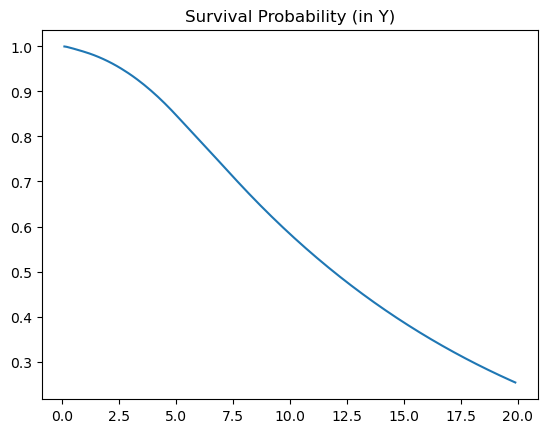

In [7]:
disc = pricing.FlatCurve(.01)  # discount curve assumed to be given (e.g. from Futures + Swaps)

terms = np.array([.25, .5, 1., 2, 3, 4, 5, 6, 7, 8, 10])
quoted_spreads = np.array([80, 85, 95, 154, 222, 300, 385, 410, 451, 470, 480])

R = 0.4 # recovery rate assumption
quoted_spreads_curve = interpolation_curve.PiecewiseLinear()
quoted_spreads_curve.fit(terms, quoted_spreads*1e-4/(1-R))

survival_proba = pricing.ForwardRateCurve(quoted_spreads_curve)

t = np.arange(0.1, 20, 0.1)
plt.plot(t, survival_proba(t))
plt.title("Survival Probability (in Y)")

In [8]:
R = 0.4 # recovery rate
cps = np.ones(len(terms))*100
insts = [pricing.CDS(m, c*1e-4, recovery = R) for m, c in zip(terms, cps)]

#compute the upfront PV of the benchmark instruments
# uses approximation for the 
ufr = np.array([i.pv01(disc, survival_proba)*(c-sp)*1e-4 for i, sp, c in zip(insts, quoted_spreads, cps)])

mat_tag = 'Maturity (Y)'
#pd.set_option('precision', 4)

cds_data = pd.DataFrame({mat_tag:terms, 'Coupon(bps)':cps, 'Quoted Spread(bps)':quoted_spreads, 'PV (% Points)': ufr*100.}).set_index(mat_tag)
fmt.displayDF(cds_data.T, "4g", fontsize=2)
benchmarks = dict(zip(insts, ufr))

Maturity (Y),0.25,0.5,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,10.0
Coupon(bps),100,100,100,100,100,100,100,100,100,100,100
Quoted Spread(bps),80,85,95,154,222,300,385,410,451,470,480
PV (% Points),0.04979,0.07447,0.04934,-1.051,-3.503,-7.504,-13.05,-16.58,-21.27,-24.84,-29.85


* the CDS contract have standardised semi-annual maturities, on Mar-20 and Sep-20
* it usually costs more per annum for longer term contracts
* for most names, there are only a few liquid CDS instruments, referred as the benchmark instruments
* quoted spreads is a way to communicate the upfront payment, it loosely corresponds to the zero rate or yield in IR

## What to interpolate?

It is important to choose the right quantity to interpolate

* There are many potential choices, e..g: $f(t), f'(t)$ or $\int_0^t f(s) ds$ etc.
* Which variable is a natural fit for tension spline's stretch operation?
* We want the variable itself to be continuous, but can live with the discontinuities in $f'(t)$ when $\lambda \rightarrow \infty$

Industry standard:
$$p(t) = e^{-\int_0^t h(s) ds}$$
* build piecewise flat curve in hazard rate $h(t)$ for CDS:
* where $p(t)$ is the survival probability of the reference entity at time $t$. 

This is quite odd, why don't we use a continuous interpolation in $h(t)$?
* such as piecewise linear or cubic spline?

## Triangular dependency

The objective:
* build a curve in hazard rate $\bs h(t)$ that exactly reproduce all observed CDS prices quoted in $\bs q(t)$

||h(3m)|h(6m)|h(1Y)|h(2Y)|h(5Y)|
|:----:| ----: | ----: | ----: | ----: | ----: |
|$q(3m)$| X |   |   |   |   | 
|$q(6m)$| * | X |   |   |   | 
|$q(1Y)$| * | * | X |   |   | 
|$q(2Y)$| * | * | * | X |   | 
|$q(5Y)$| * | * | * | * | X |

Bootstrap is the standard method to build curves with triangular dependency:
* Solve the knot values one by one, using benchmark instruments with increasing maturities

## Piecewise flat bootstrap

* This is the standard approach to build CDS curves in the industry
* $g(t)$ is the cumulative hazard: $g(t) = \int_0^t h(s) ds = -\log(p(t))$
* Piecewise flat in hazard rate $h(t)$ is equivalent to piecewise linear in $g(t)$

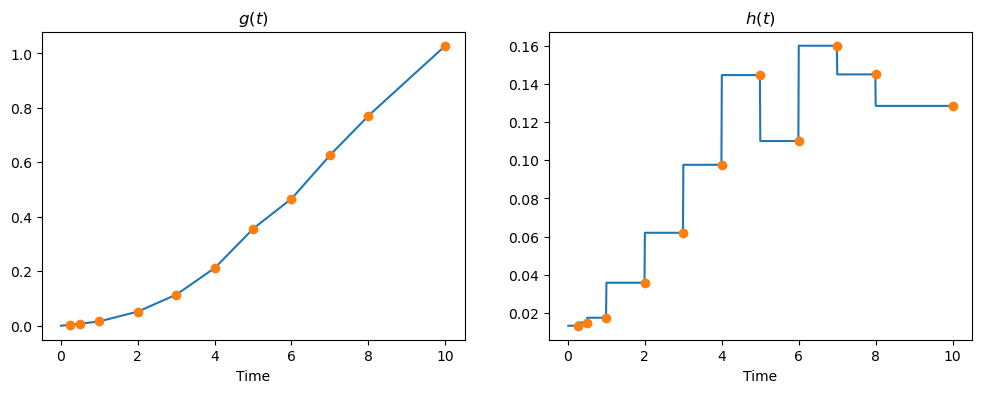

In [9]:
cds_pv = pricing.cds_pv_func(disc, pricing.DiscountCurve.yield2disc)

hlin = interpolation_curve.PiecewiseLinear()
hlin.fit(terms, [100*1e-4]*len(terms))
hlin.insert(0, 0)

hlin = pricing.bootstrap(benchmarks, hlin, cds_pv, bds = [-1., 1.2])

cds_data['PV Error (bps) - Linear'] = np.round([1e4*(cds_pv(i, hlin) - benchmarks[i]) for i in insts], 4)

xs = np.arange(.01, 10, .01)

plt.figure(figsize=[12, 4])
plt.subplot(1, 2, 1)
plt.plot(xs, hlin(xs))
plt.plot(terms, hlin(terms), 'o')
plt.xlabel('Time')
plt.title('$g(t)$');

plt.subplot(1, 2, 2)
plt.plot(xs, hlin.derivate(xs))
plt.plot(terms, hlin.derivate(terms-1e-4), 'o')
plt.xlabel('Time')
plt.title('$h(t)$');

## Pros and cons of piecewise flat bootstrap

* All benchmark prices are exactly matched, after bootstrap with piecewise flat hazard rate.
* Discontinuity in hazard rate causes hedging problems, risk profiles jump over the roll dates.

In [10]:
fmt.displayDF(cds_data.T, "4g", fontsize=2)

Maturity (Y),0.25,0.5,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,10.0
Coupon(bps),100,100,100,100,100,100,100,100,100,100,100
Quoted Spread(bps),80,85,95,154,222,300,385,410,451,470,480
PV (% Points),0.04979,0.07447,0.04934,-1.051,-3.503,-7.504,-13.05,-16.58,-21.27,-24.84,-29.85
PV Error (bps) - Linear,-0,0,0,-0,0,0,-0,-0,0,0,0


How to remove the discontinuity in hazard rate?
* applying cubic spline to hazard rate seems to be a natural idea, does it work?

## Cumulative hazard

The cumulative hazard $g(t)$ is a suitable variable for the tension spline interpolation:

$$g(t) = \int_0^t h(s) ds = -\log(p(t))$$

* $g(t)$ is continuous and monotonic, 1 to 1 with $p(t)$
* $g(0) = 0$, the boundary condition is well defined
* $h(t) = g'(t)$ can be discontinuous when $\lambda \rightarrow \infty$, this reverts to the standard method of piecewise flat hazard rate
* with finite $\lambda$, hazard rate is smooth and continuous

This argument carries over to the interest rate curve building:

* the cumulative yield, $y(t) = -\log(b(t))$, is a suitable variable to apply tension spline

## Bootstrap with tension spline

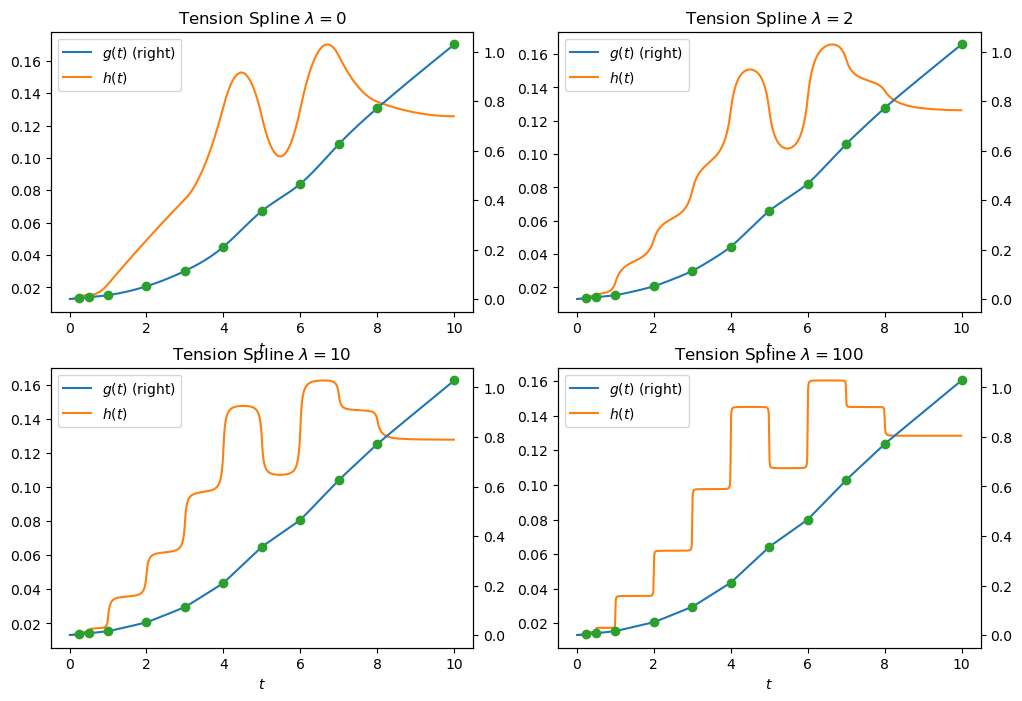

In [11]:
def plotboot(tsit, lbd, ax, tagsf) :
    plt.xlabel('Time')    
    
    lbd_tag = '$\\lambda=%.f$' % lbd
    df = pd.DataFrame({'$t$':xs}).set_index(['$t$'])
    
    for tag, f in tagsf :
        df[tag] = f(tsit, xs) 
    
    df.plot(ax = ax, secondary_y = [tagsf[0][0]], title = 'Tension Spline ' + lbd_tag)
    plt.plot(terms, tsit(terms), 'o')

tagsf = [("$g(t)$", lambda cv, xs : cv(xs)), ("$h(t)$", lambda cv, xs : cv.derivate(xs))]

lbds = [0, 2, 10, 100]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=[12, 8])

es = []

for lbd, ax in zip(lbds, axes.flatten()) :
    tsit, e = pricing.iterboot(benchmarks, cds_pv, lbd=lbd, bds=[-1, 1.1], x0=0, its=1)
    plotboot(tsit, lbd, ax, tagsf)  
    es.append(e[0])

## Bootstrapping with global interpolation

The benchmark CDS won't reprice exactly after the bootstrapping with tension spline:
* Changes in longer maturity affects the shorter end of the curve
* The dependency matrix is no longer triangular, but close

## Iterative algorithm

Iteration is an effective method for near triangular dependency:

$$\bs x^{i+1} = f(\bs x^i)$$

* where $f(\cdot)$ represent the bootstrap operation, $\bs x^i$ is knot solutions
* $\bs x^0$ is a initial guess, e.g. a flat curve
* simple and effective, usually outperforms sophisticated optimizers

## Iteration with mixing

Mixing the old and new results between iterations improves stability:

$$\bs x^{i+1} = m f(\bs x^i) + \left(1-m\right) \bs x^i$$

* $m = 0.5$ is often a good choice

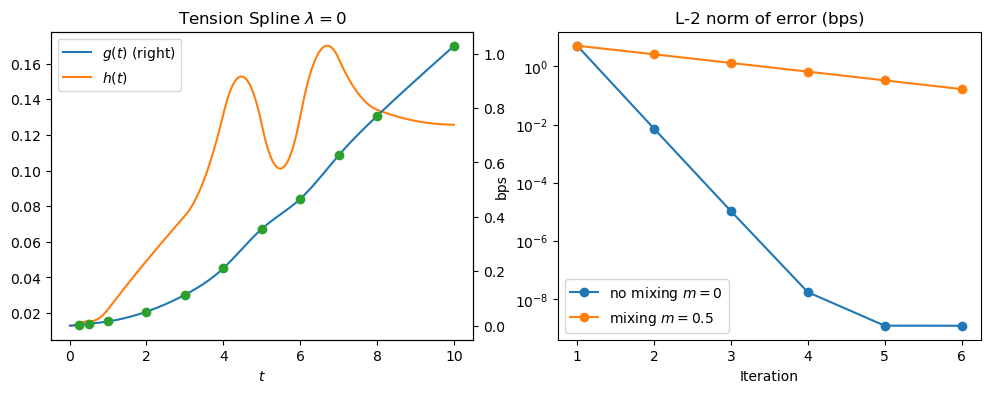

In [12]:
plt.figure(figsize=[12, 4])
ax = plt.subplot(1, 2, 1)

tsit, e = pricing.iterboot(benchmarks, cds_pv, bds=[-1, 1.2], x0=0, lbd = lbds[0], its=6)  # mixf = 0.
tsit1, e1 = pricing.iterboot(benchmarks, cds_pv, bds=[-1, 1.2], x0=0, lbd = lbds[0], mixf=0.5, its=6) # mixf = 0.5

plotboot(tsit, lbds[0], ax, tagsf)    

plt.subplot(1, 2, 2)
plt.semilogy(range(1, len(e)+1), np.transpose([np.linalg.norm(e, 2, 1)*1e4, np.linalg.norm(e1, 2, 1)*1e4]), 'o-')
plt.legend(['no mixing $m=0$', 'mixing $m=0.5$'], loc='best')

plt.xlabel('Iteration')
plt.ylabel('bps')
plt.title('L-2 norm of error (bps)');

## Effects of tension parameter $\lambda$

* No visible difference in $g(t)$
* Big difference in the hazard rate $h(t)$
  * the smaller $\lambda$, the smoother the $h(t)$

In [13]:
def pv_lbds(bms, cdspv, lbds, x0) :
    cvs = []
    for lbd in lbds:
        cv, e = pricing.iterboot(bms, cds_pv, x0, lbd, mixf = 0.5, bds=[-1, 1.1])
        cvs.append(cv)
    
    return cvs

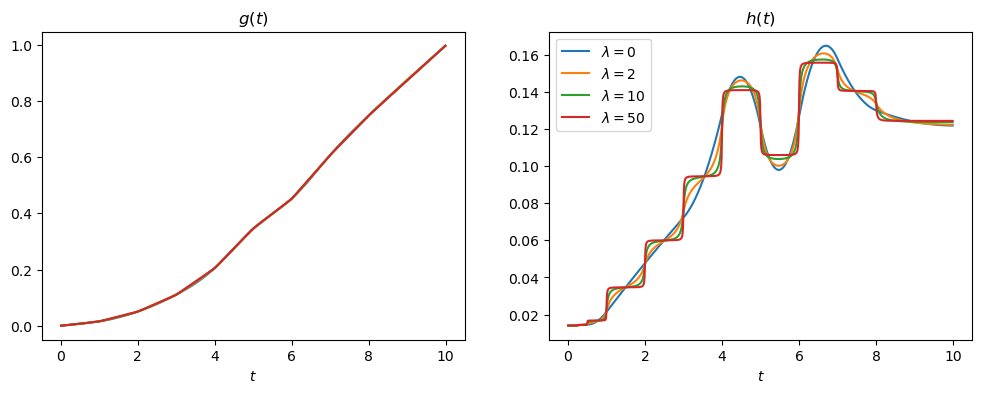

In [14]:
lbds = (0, 2, 10, 50)
tags = ['$\\lambda=%.f$' % l for l in lbds]
cv0 = pv_lbds(benchmarks, cds_pv, lbds, 0)

plt.figure(figsize=[12, 4])
plt.subplot(1, 2, 1)
plt.plot(xs, np.array([cv(xs) for cv in cv0]).T);
plt.title('$g(t)$')
plt.xlabel('$t$')

plt.subplot(1, 2, 2)
plt.plot(xs, np.array([cv.derivate(xs) for cv in cv0]).T);
plt.legend(tags, loc='best');
plt.title('$h(t)$');
plt.xlabel('$t$');

## Perturbation locality

Changes in hazard rates are more localized with larger $\lambda$
* A highly desirable property in practice

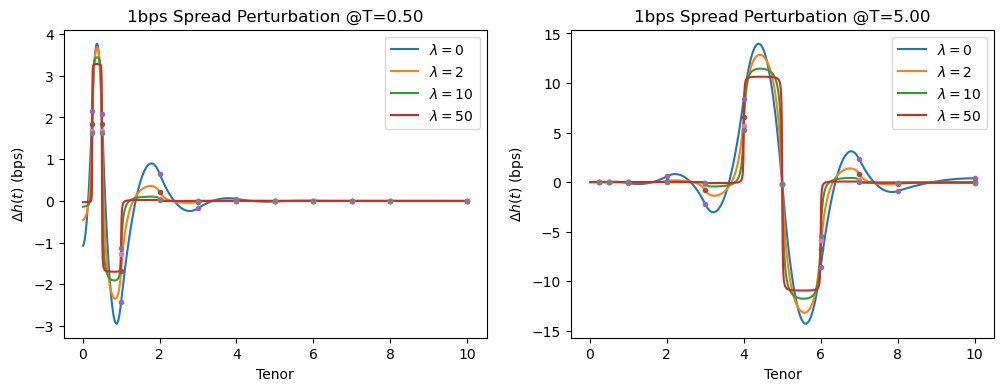

In [15]:
def showPerts(bms, bms_ps, cds_pv, lbds, x0, pertf) :
    cv0 = pv_lbds(bms, cds_pv, lbds, x0=x0)
    cvp1, cvp2 = [pv_lbds(b, cds_pv, lbds, x0=x0) for b in bms_ps]
    
    lbd_tags = ['$\\lambda=%.f$' % lbd for lbd in lbds]

    plt.figure(figsize=[12, 4])

    plt.subplot(1, 2, 1)
    plt.plot(xs, 1e4*np.array([pertf(f, g)(xs) for f, g in zip(cv0, cvp1)]).T);
    plt.xlabel('Tenor')
    plt.ylabel('$\Delta h(t)$ (bps)')
    plt.title('1bps Spread Perturbation @T=%.2f' % pts[0])
    plt.legend(lbd_tags, loc='best');
    plt.plot(terms, 1e4*np.array([pertf(f, g)(terms) for f, g in zip(cv0, cvp1)]).T, '.');

    plt.subplot(1, 2, 2)
    plt.plot(xs, 1e4*np.array([pertf(f, g)(xs) for f, g in zip(cv0, cvp2)]).T);
    plt.xlabel('Tenor')
    plt.ylabel('$\Delta h(t)$ (bps)')
    plt.title('1bps Spread Perturbation @T=%.2f' % pts[1])
    plt.legend(lbd_tags, loc='best');
    plt.plot(terms, 1e4*np.array([pertf(f, g)(terms) for f, g in zip(cv0, cvp2)]).T, '.');
    
    
pts = [.5, 5.]
bms_ps = [{k if k.maturity != pt else pricing.CDS(k.maturity, k.running_coupon-1e-4, recovery=k.recovery) : v 
        for k, v in benchmarks.items()} for pt in pts]
    
showPerts(benchmarks, bms_ps, cds_pv, lbds, 0, lambda f, g : lambda xs : f.derivate(xs) - g.derivate(xs))

# Concepts of Derivatives and Hedging

A financial derivatives is a contract for which in general the seller has a (legal) liability toward the buyer. Often, there are market observables (stock prices, interest rates, pool of loans, etc.) and a derivatives contract bind a seller and a buyer with the obligation for one (or both) to pay (or receive) something to the other counterpart.

Derivatives can be used for various kind of investment purposes, but the general theory of pricing, i.e. how much should be paid to own a derivatives contracts works as follow:
- Market observables are well defined, e.g. stock prices, IR swaps prices, CDS prices, etc.
- A liquid market of basic instruments exists, e.g. stocks or futures can be traded
- The seller of the derivatives can (in theory) trade in this contract all the time, e.g. can buy or sell stocks, IR swaps, etc.
- If, starting from an initial capital amount $p_0$, the seller of the contract can put in place a trading strategy which enables him to fullfil his obligation toward the buyer at maturity of the contract (complete market assumption), then an arbitrage free argument gives that $p_0$ should be the (fair) price of the derivatives contracts.
- The above argument is theoretical and it's not clear how to compute $p_0$ or the corresponding strategies.
- How does one make money then ? Well, "just" sell at $p_0 +$ "small"(?) extra premium and keep selling a lot of contracts.

Complications in real world are:
- Hedging is not perfect and having a good hedging strategy is often challenging.
- There are many sources of uncertaininty: statistical noise in the data.
- Liquidity is not perfect, transaction costs, market impact, etc.
- Many more...

## Interpolate the hazard rate?

The result is disastrous:

* When $\lambda \rightarrow \infty$, it approaches linear interpolation in the hazard rate
* Linearly interpolating $h(t)$ leads to zigs and zags

<div class="alert alert-block alert-info">
Hedging can be conceptually summarize as: <p>
- A "private" portfolio <p>
- A market portfolio <p> 
- A risk measure <p>
- Market change scenarios <p>
Goal: find the best market portfolio that minimize the risk measure over all the scenarios.
</div>

## Finite difference

Hedging involves the calculation of (partial) derivatives with respect to various risk factors. the principle is simple: a (small) change in a risk factor induces a change in the valuation of a portfolio, then trading a basic instrument on that risk factor in the opposite direction should off-set (ideally totally, in practice partially) this risk.<br>

The derivative of a smooth function $f(t)$ can be approximated numerically by finite difference schemes:

* Forward difference: $f'(x) \approx \frac{f(x+\epsilon) - f(x)}{\epsilon} + O(\epsilon)$
* Backward difference: $f'(x) \approx \frac{f(x) - f(x-\epsilon)}{\epsilon} + O(\epsilon)$
* Central difference: $f'(x) \approx \frac{f(x+\epsilon) - f(x-\epsilon)}{2\epsilon} + O(\epsilon^2)$
* 2nd order derivative: $f''(x) \approx \frac{f(x+\epsilon) - 2f(x) + f(x-\epsilon)}{\epsilon^2} + O(\epsilon^2)$

Central scheme has higher order of accuracy but requires two valuations of $f$. The accuracy of finite difference schemes can be verified via Taylor expansions.

<div class="alert alert-block alert-warning">
Check that it is <b>not</b> a good idea to use the central difference scheme twice to compute $f''(x)$
</div>

## Generic pricing function

A pricing function can be written very generically as: $\renewcommand{bs}{\boldsymbol} v = v(\bs i, \bs m, \bs c, t)$, the inputs are:

* $\bs i$: the instrument itself, such as maturity, coupon rate etc
* $\bs m$: market environment, such as IR, CDS, FX rate etc
* $\bs c$: model parameters and assumptions, 
  * static parameters, e.g.: the tension spline parameter $\lambda$ 
  * parameters calibrated to market inputs, e.g.: spot/vol correlation
* $t$: time

Even this is pricing representation is simplified as the parameters in the model $\bs c$ can depend on market state $\bs m$ and we would have $\bs c(m)$ instead. Mathematically, this means the chain rule is needed when computing partial derivatives. Conceptually however, the situation is essentially the same.
***
The pricing function can be viewed as as tool doing many things:
- Interpolation for prices not obersable between market quotes (e.g. because of seasoned instruments sittong on the books, or for OTC instruments)
- A device to project many risk factors (e.g. all the implied volatilities from the market) on a reduce number of risk factors (e.g. stock, mean-reversion, stochastic volatility, etc.)

## Greeks

The following terminologies are often used in practice
* Delta: 1st order derivative to market variables: $\Delta = \frac{\partial v}{\partial \bs m}$
 * Delta is a vector of size $m$
 * Deltas are (often expressed) in the unit of currency
* Gamma: 2nd order derivatives to market variables: $\Gamma = \frac{\partial \Delta}{\partial \bs m} =\frac{\partial^2 v}{\partial^2 \bs m} $
 * Gamma is a $m \times m$ matrix that includes all cross gammas
* Theta: $\theta = \frac{\partial v}{\partial t}$
* Delta is also defined for certain common model parameters:
 * Vega: derivative w.r.t. implied volatility

## How to compute Deltas

Deltas are often computed by brute force
  * bump, recalibrate (curves & other model parameters), revalue
  * slow, but generic and robust most of the time (there are always edge cases)

The calcualtion depends on the risk factor representation, e.g.:
- Swap rates vs Zero rates
- CDS spreads vs Hazard rates
- Implied Volatilities at given strike/maturity vs geometrical representation of risk in terms of level, Skew, convexity.

Advanced method of computing Delta
  * algorithmic adjoint differentiation
  * Jacobian inversion

## Dynamic hedging

Let's consider a portfolio P having positions in several liquid/benchmark market instruments $b_i$. 
$$ P_t = \sum_{i=1}^N \Delta_t^i b_t^i + cash  = \Delta^T b + cash$$

<div class="alert alert-block alert-warning">
It is crucial to keep in mind that a (hedging/trading) portfolio is <b>linear</b>  with respect this its instruments usually (that's the financial meaning of taking a position in a market instrument).
</div>
The purpose of dynamic hedging is to remove the unwanted risks by trying to neutralize one's exposure to risk factors at each point in time (why do we do that again? What is the point of being market neutral if we want to make money from market moves?):

* Compute Deltas to all relevant market risk factors
* Aggregate the risk sensitivities at the portfolio level
* Put on hedges that neutralize the portfolio's sensitivities to unwanted risk factors
* The hedges are rebalanced frequently
* Dynamic hedging allows a market maker to trade and risk manage illiquid derivatives using more liquid instruments
* Risk managers impose limits on deltas to key risk factors

<div class="alert alert-block alert-info">
Unless cash is a risk factor itself (e.g. the underlying is an FX-rate), the cash component is usually omitted when taking into account market risk consideration as it is used only for self financing purposes. It is sometimes important to consider it for funding considerations.
</div>

## P&L explain:

* Attribute daily P&L to market risk factor changes
* A critical step for a trading desk's operation in practice

At a first order (i.e. very high level), the PnL explain is the total derivative:

$$\renewcommand{bs}{\boldsymbol}  d v = \frac{\partial v}{\partial \bs i} d \bs i + \frac{\partial v}{\partial \bs m} d \bs m + \frac{\partial v}{\partial \bs c} d \bs c + \frac{\partial v}{\partial t} dt $$

* if the two sides differ a lot, the dynamic hedging is not working.
* on a normal day, the explained PnL should be (almost) total.
* in equity/FX, (half of) the gamma contribution of the underlying(s) is also added, i.e. $\bs dm^T \frac{\partial^2 v}{\partial \bs m^2} d \bs m $ where $\frac{\partial^2 v}{\partial \bs m^2}$ is the Hessian matrix.
* if the P&L is of poor quality, second order risk are the considered.

## Replicating and hedging portfolio

Given: 

* $v$ is the PV of the trade or portfolio to be hedged
* $\bs b$ is a vector of **b**enchmark instruments' **PV**s 
  * $\bs b$ is usually in unit notional, by convention
* $\bs q$ is the vector of benchmark **q**uotes
  * e.g. the quoted spreads for CDS, par swaps for rates, implied vol, etc.

We have then (the $\sim$ is because we leave cash aside and just consider risk factors via the (hedging) market instruments)<br>
$$v \sim h^T b = \sum_i h_i b_i = \sum_i \Delta_i S_i$$

The replicating portfolio $\bs h^T \bs b$ is a benchmark portfolio that has identical **first order** risk to $v$: 

$$\frac{\partial v}{\partial \bs q}  = \frac{\partial (\bs h^T \bs b)}{\partial \bs q} = \bs h^T  \frac{\partial \bs b}{\partial \bs q} \iff \bs h^T = \frac{\partial v}{\partial \bs q} \left(\frac{\partial \bs b}{\partial \bs q}\right)^{-1} $$

The element of $\bs h$ are sometimes referred to as the "**h**edging ratios", or the deltas.

<div class="alert alert-block alert-info">
Writing $dv \sim h^T db$ and from the fact that also $dv \sim \partial_q v^T dq$ and similarly $db \sim \partial_q b^T dq$, which essentially amonunts to a change a variable, you can always easily retrive the hedging formulas.    
</div>

Or more directly:

$$
\bs h^T = \frac{\partial v}{\partial \bs b} = \frac{\partial v}{\partial \bs q}\frac{\partial \bs q}{\partial \bs b} = \frac{\partial v}{\partial \bs q}\left(\frac{\partial \bs b}{\partial \bs q}\right)^{-1}
$$

* $\frac{\partial v}{\partial \bs q}$ are the Deltas of the bespoke instrument
* $\frac{\partial \bs b}{\partial \bs q}$ are the Deltas of the benchmark instruments.

$P = -\bs h^T \bs b$ is the portfolio to neutralize all the first order risks, commonly referred to as the hedging portfolio.

* this equation is the core of a market maker's operation
* we can trade illiquid instrument and hedge them using liquid benchmarks
* economy of scale: hedging is performed at the portfolio level

## Benchmark Jacobian

$\frac{\partial \bs b}{\partial \bs q}$ is the Jacobian (matrix) of benchmark instruments over benchmark quotes

## Diagonality

The benchmark Jacobian is diagonal if the dependency btw $\bs b$ and $\bs q$ is one to one
  * Jacobian $\frac{\partial v}{\partial \bs q}$ requires other elements of $\bs q$ remain constant when perturbing one of them
  * other benchmark PVs remain unchanged because their $\bs q$ are hold constant
  
The $\bs b$ and $\bs q$ are not always one-to-one
  * eg, option price depends on both IR and implied vol
  * the benchmark quote is not diagonal in this case  

# Hedge Optimization

## Cost of hedging

Hedging are costly in practice

* bid/ask, capital, financing, rebalancing  etc

But not hedging can results in higher financial loss.

We need to minimize the cost of hedging:
 * desks/traders often choose not to zero out all unwanted risks
 * there are only a limited number of liquid and cost effective hedging instruments

How to get the best results using a limited number of hedging instruments? <br>
$\Rightarrow$ define what is best first

## Hedge optimization

We can formulate the problem as an optimization problem:

* a set of benchmark instruments $\bs b$ with quotes $\bs q$
* limited set of hedging instruments $\bs u$, whose deltas to $\bs q$ is the Jacobian $J = \frac{\partial \bs u}{\partial \bs q}$ 
 * the dimension of $\bs u$ is smaller than $\bs q$, $J$ is rectangular
* the portfolio PV is $v$ and its deltas are: $\bs d = (\frac{\partial v}{\partial \bs q})^T$
* we use $\bs h$ to represent the best replicating portfolio, it has the same dimension as $\bs u$
  * the hedging portfolio is of course $-\bs h$

## Minimize the residual risk

The residual risk is the remaining risk after including the hedges, we can find a replicating portfolio that minimizes its L-2 norm:

$$\min_{\bs h} \Vert J^T \bs {h - d} \Vert_2$$

* a standard least square problem, the solution is (recall $J^+$ is the pseudo-inverse of $J$):

$$ \bs h = (JJ^T)^{-1}J\bs d = J^+ \bs d$$

* this approach is simple and useful in practice

Ridge regression is an easy improvement, by adding a penalty of $\varepsilon \Vert W \bs h \Vert_2^2$:

$$ \bs h = (JJ^T + \varepsilon W^T W)^{-1}J\bs d $$

## Minimize the variance

Given the covariance matrix $V$ of the risk factors $\bs q$'s *daily changes*, the variance of the hedged portfolio is:

$$\text{var} = (J^T \bs {h - d})^T V (J^T \bs {h - d})$$

The optimal replicating portfolio that minimizes the var is:

$$\small \begin{array}
\\ \frac{\partial \text{var}}{\partial \bs h} &= 2(J^T \bs {h - d})^T V \frac{\partial(J^T \bs {h - d})}{\partial \bs h} = 2(J^T \bs {h - d})^T V J^T = \bs 0 \\
\bs h^T JVJ^T &= \bs d^T V J^T \iff
JVJ^T \bs h = J V \bs d \\
\bs h &= (JVJ^T)^{-1} J V \bs d
\end{array}$$

* this approach takes into account the covariance of risk factors.

The Ridge version is:

$$\bs h = (JVJ^T + \lambda W^T W)^{-1} J V \bs d $$

<div class="alert alert-block alert-info">
<b>Remark:</b> dynamic hedging in continuous (time) finance is doing exactly this over an infinitesimal period of time $dt$ as at the infinitesimal scale, the portfolio is linear w.r.t. to the risk factors (hence the notion of derivatives and its usage in hedging and risk management.
</div>

## Theta

In practice, we usually don't actively hedge Theta, instead we monitor it

* Source of Theta includes reduction in maturity and accrual of coupon 
* The passing of time is not volatile, it is not considered a risk factor
* Different hedges can lead to different theta profile
* It is neither feasible nor necessary to maintain a flat theta
 
Theta and convexity are often the trade off.
* Positive theta usually means negative convexity, and vice versa
* Theta is monitored to offset the gamma

Theta calculation can be very tricky and required assumption
* as time passes, how does the discount curve changes? (constant forward rate? zero coupon rate?)
* How do the equity stock prices of FX rates change?
* How do the implied volatilities change?



## A Statistical Approach to Hedging

Calculating partial derivatives can be seen as simple scenarios where:
- Risk factors moves one at a time
- All scenarios have the same probability to occur

Let's assume we have a number $N$ of market shocks representing potential risk scenarios. For each scenario, the portfolio and corresponding hedging corresponding to the delta $h$ would be affected. The cost of mishedge on one scenario is
$$ \varepsilon_k(h) = v(i, m + \delta m_k, c + \delta c_k, t+\delta_t) - \sum_i h_i b_i^{(k)}$$

where
- $\delta m_k$ is the change in the market data. This can be done historically or using ad hoc scenarios, or even simulated scenario
- $\delta c_k$ is the change in the model parameters (often induced by a change of market data, but not only)
- $\delta t$ represents the length of typical re-hedging period (could set $\delta t=0$ for intraday hedging or $\delta t =1/252$ for daily/overnight hedging, assessing effect of decay.

<div class="alert alert-block alert-warning">
**Beware:** computing $v(i, m + \delta m_k, c + \delta c_k, t+\delta_t)$ could be (very) time consuming.
</div>
    
The cost of hedging is (still)
$$ TC = \frac{1}{2}\sum_i |h_i|(bid_i - ask_i)$$

Similar to a Bayesian approach, some probability $p_k$ can be associated to scenario $k$ (e.g. $p_k = 1/N$). Then various minimization criterion could be used:
- $L_2$ or $L_1$
$$ \sqrt{\sum_k p_k \varepsilon_k(h)^2} + TC $$
$$ \sum_k p_k | \varepsilon_k(h) | + TC $$

- tail risk ($\eta$ is used to scale $TC$ reasonably
$$ \sum_k p_k 1_{\{\varepsilon_k(h) < -maxLoss  \}} + \eta TC $$

- And we can mix, for isntance to have a mean-square hedge efficient, while limiting tail/jump risk and
$$ $$

Pros:
- can catpure cross and higher order risk such as gamma, vanna, volga.
- Specific risk scnearios (jump, crash, covid-19...) can be embedded and analyzed.
- computing the change in value of benchmark instruments is (usually) very cheap.
- Hedging criterion easy to adapt to specific situations.
- Smoothing/regularization has a natural financial interpretation in terms of transaction costs.

Cons:
- Can be computationally heavy for large portfolio and/or exotic products calculation (model recalibration, etc.)


## Example: Basket option in Black-Scholes

option payoff 
$$ \left(\frac{1}{3}\left(\frac{S^1_T}{S^1_0}+\frac{S^2_T}{S^2_0}+\frac{S^3_T}{S^3_0} \right) -1 \right)^+ $$

Hedging instruments are the corresponding ATM options and the corresponding stocks (i.e. 6 instruments).


In [16]:
# Market, product and pricing data
aapl = 165
goog = 109
amzn = 102

stocks = [aapl, goog, amzn]

sigma_appl = 22.35/100.
sigma_goog = 31.4/100.
sigma_fb = 33.52/100.

vols = [sigma_appl, sigma_goog, sigma_fb]

correl = np.array([[1., 0.9, 0.8],
                 [0.9, 1., 0.85],
                 [0.8, 0.85, 1.]])

correl.shape =[3,3]
T= 1
nb_paths = int(2**15-1)

In [17]:
# Simple pricing function (for illustration purposes only)
def basket_option_mc(s: list, vol: list, correl_m, fixings:list, strike: float, T: float, nb_paths: int, weights=None):
    np.random.seed(42)
    nb_assets = len(s)
    sT = np.array(s)
    sT.shape = [len(s), 1]
    fixings = np.array(fixings)
    fixings.shape = [nb_assets, 1]
    sigma = np.array(vol)
    sigma.shape = [nb_assets, 1]
    sqrt_T = np.sqrt(T)

    if not weights:
        weights = np.ones(nb_assets)
        weights.shape = [nb_assets, 1]
        weights = weights / np.sum(weights)

    dZ = np.random.standard_normal((nb_assets, nb_paths))
    dZ = np.linalg.cholesky(correl_m) @ dZ

    sT = sT*np.exp(-0.5 * sigma ** 2 * T + sqrt_T * sigma * dZ)
    sT = sT/fixings
    return np.mean(np.maximum(0, np.mean(sT, axis=0) - strike))

# not needed but in case you want to experiment the impact of MC noise on hedging ratios
def call_bs_mc(s: list, vol: list, correl_m, strikes: list, T: float, nb_paths: int):
    np.random.seed(42)
    nb_assets = len(s)
    sT = np.array(s)
    sT.shape = [len(s), 1]
    sigma = np.array(vol)
    sigma.shape = [nb_assets, 1]
    sqrt_T = np.sqrt(T)

    dZ = np.random.standard_normal((nb_assets, nb_paths))
    dZ = np.linalg.cholesky(correl_m) @ dZ

    sT = sT * np.exp(-0.5 * sigma ** 2 * T + sqrt_T * sigma * dZ)
    return np.mean(np.maximum(0., sT * np.exp(-0.5 * sigma ** 2 * T + sqrt_T * sigma * dZ)), axis=1)
    

In [18]:
# Simple black-scholes functions assumes, zero IR, zero Div
def price_call_bs(F, K, vol, T):
    sqrt_T = np.sqrt(T)
    total_vol = vol*sqrt_T

    d = np.log(F/K)/total_vol + 0.5*total_vol
    return F*norm.cdf(d) - K*norm.cdf(d-total_vol)

def delta_call_bs(F, K, vol, T):
    sqrt_T = np.sqrt(T)
    total_vol = vol*sqrt_T

    d = np.log(F/K)/total_vol + 0.5*total_vol
    return norm.cdf(d)


def vega_call_bs(F, K, vol, T):
    sqrt_T = np.sqrt(T)
    total_vol = vol*sqrt_T

    d = np.log(F/K)/total_vol + 0.5*total_vol
    return norm.pdf(d)*F*sqrt_T

In [19]:
# compute base prices and deltas of basket options
np.random.seed(42)
basket_option = basket_option_mc(stocks,
                                 vols,
                                 correl,
                                 fixings=stocks,  # assume starting and pricing EOD
                                 strike=1, T=T, nb_paths=nb_paths)

# For expirimentation purposes only
#vanilla_options = call_bs_mc(stocks,
#                             vols,
#                             correl,
#                             strikes=[1]*len(stocks), T=T, nb_paths=nb_paths)

vanilla_options = [price_call_bs(s, s, vol, 1.) for (s,vol) in zip(stocks, vols)]

stock_bump_size = 0.01
vol_bump_size = 0.01

deltas = []
for i in range(len(stocks)):
    tmp = copy(stocks)
    tmp[i] = tmp[i]*(1+stock_bump_size)
    price_up = basket_option_mc(tmp,
                                vols,
                                correl,
                                fixings=stocks,
                                strike=1, T=T, nb_paths=nb_paths)

    tmp = copy(stocks)
    tmp[i] = tmp[i] * (1 - stock_bump_size)
    price_down = basket_option_mc(tmp,
                                  vols,
                                  correl,
                                  fixings=stocks,
                                  strike=1, T=T, nb_paths=nb_paths)

    deltas.append((price_up-price_down)/(2*stock_bump_size))

vegas = []
for i in range(len(vols)):
    tmp = copy(vols)
    tmp[i] = tmp[i] +vol_bump_size
    price_up = basket_option_mc(stocks,
                                tmp,
                                correl,
                                fixings=stocks,
                                strike=1, T=T, nb_paths=nb_paths)

    vegas.append((price_up - basket_option)/vol_bump_size)

dv_dq = np.array(deltas + vegas)

deltas_vanilla = [delta_call_bs(s, s, vol, T=T) for (s,vol) in zip(stocks, vols)]
vegas_vanilla = [vega_call_bs(s, s, vol, T=T) for (s,vol) in zip(stocks, vols)]

In [20]:
db_dq = np.array(deltas_vanilla + vegas_vanilla)
hedging_ratios = dv_dq / db_dq

In [21]:
cols= ["s"+ str(i) for i in range(len(stocks))] + ["vol"+str(j) for j in range(len(vols))]
hedging_ratios.shape = [1, len(hedging_ratios)]

In [22]:
h = pd.DataFrame(hedging_ratios, columns = cols)
h.index = ['Hedging ratios']
h

,s0,s1,s2,vol0,vol1,vol2
Hedging ratios,0.3213,0.3335,0.3343,0.001901,0.002972,0.003117


In [23]:
hedging_ratios = dv_dq / db_dq

In [24]:
# full jacobian matrix (for this example) of benchmark instruments

db_dq_jac = np.zeros((len(stocks)+len(vols), len(stocks)+len(vols)))
db_dq_jac.shape = ((len(stocks)+len(vols), len(stocks)+len(vols)))

for i in range(len(stocks)):
    db_dq_jac[i][i] = 1.0
    db_dq_jac[i][i+len(stocks)] = deltas_vanilla[i]
    
for i in range(len(vols)):
    db_dq_jac[i+len(stocks)][i+len(stocks)] = vegas_vanilla[i]


In [25]:
db_dq_jac_matrix = pd.DataFrame(db_dq_jac)
db_dq_jac_matrix.columns =  ['S_' + str(i) for i in range(len(stocks))] + ['C_' + str(i) for i in range(len(vols))]
db_dq_jac_matrix.index =  ['S_' + str(i) for i in range(len(stocks))] + ['vol_' + str(i) for i in range(len(vols))]
db_dq_jac_matrix

,S_0,S_1,S_2,C_0,C_1,C_2
S_0,1,0,0,0.5445,0,0
S_1,0,1,0,0,0.5624,0
S_2,0,0,1,0,0,0.5666
vol_0,0,0,0,65.42,0,0
vol_1,0,0,0,0,42.95,0
vol_2,0,0,0,0,0,40.12


In [26]:
new_hedging_ratios = dv_dq @ np.linalg.inv(db_dq_jac)
new_hedging_ratios.shape  = [1, len(new_hedging_ratios)]

In [27]:
h_new = pd.DataFrame(new_hedging_ratios, columns = cols)
h_new.index = ['Full Jac Hedging ratios']
h_new

,s0,s1,s2,vol0,vol1,vol2
Full Jac Hedging ratios,0.1749,0.1876,0.1894,0.000445,0.0005165,0.000443


In [28]:
new_hedging_ratios = dv_dq @ np.linalg.inv(db_dq_jac)

In [29]:
# Build scenarios stocks and volatility

# Need extra (modeling) assumptions (spot/vol correlation, vol of vol)
# stock and volatility are negatively correlated
# volatility are positively correlated (usually)

np.random.seed(10)

full_correl_m = np.array([[1., 0.9, 0.8, -0.8, -0.6, -0.77],
                          [0.9, 1., 0.85, -0.6, -0.5, -0.65],
                          [0.8, 0.85, 1., -0.7, -0.7, -0.8],
                          [0.0, 0.0, 0.0, 1., 0.7, 0.65],
                          [0.0, 0.0, 0.0, 0.0, 1., 0.45],
                          [0.0, 0.0, 0.0, 0.0, 0.0, 1.]])
full_correl_m.shape =[6,6]

for i in range(1, len(full_correl_m)):
    for j in range(0, i):
        full_correl_m[i][j] = full_correl_m[j][i]
    
full_vols = vols + [0.6, 0.7, 0.55]
    
nb_scenarios = 10**3

one_day = 1/252.

shocks = np.array(stocks+vols)
shocks.shape = [len(stocks)+len(vols), 1]
sigma_one_day = np.array(full_vols)
sigma_one_day.shape = [len(stocks)+len(vols), 1]
sqrt_one_day = np.sqrt(one_day)

dZ = np.random.standard_normal((len(stocks)+len(vols), nb_scenarios))
dZ = np.linalg.cholesky(full_correl_m) @ dZ

shocks = shocks * np.exp(-0.5 * sigma_one_day ** 2 * one_day + sqrt_one_day * sigma_one_day * dZ)


In [30]:
# apply scenarios to instruments and hedging portfolio
basket_options_shocks = []
vanilla_options_shocks = []

for i in range(nb_scenarios):
    shock = shocks[:,i]
    stock_shock = shock[:len(stocks)]
    vol_shock = shock[len(stocks):]
    new_T = T # did not include effect of time passing
    basket_options_shocks.append(basket_option_mc(stock_shock,
                                                  vol_shock,
                                                  correl,
                                                  fixings=stocks,  # need to keep the same fixing
                                                  strike=1, # need to keep same strike as instrument does not change
                                                  T=new_T, 
                                                  nb_paths=nb_paths))

    vanilla_options_shocks.append([price_call_bs(new_s, k, new_vol, T=new_T) for new_s, k, new_vol in zip(stock_shock, stocks, vol_shock)])
    

In [31]:
# compute P&L impacts and plot distribution
PnL = []
dBOs = []
dHedgingPtf = []

hedging_strategy = hedging_ratios
#hedging_strategy = new_hedging_ratios

delta_hedge = hedging_strategy[:len(stocks)]
vega_hedge = hedging_strategy[len(stocks):]

for i in range(nb_scenarios):
    shock = shocks[:,i]
    dS  = np.array(shock[:len(stocks)]) - np.array(stocks)
    dC = np.array(vanilla_options_shocks[i]) - np.array(vanilla_options)
    dBO = basket_options_shocks[i] - basket_option
    hedging_pnl = delta_hedge @ dS +vega_hedge @ dC
    
    dBOs.append(dBO)
    dHedgingPtf.append(hedging_pnl)
    
    pnl = hedging_pnl- dBO
    PnL.append(pnl)

(array([ 1.,  0.,  1.,  2.,  4.,  2.,  3.,  5.,  6., 12., 13., 11., 21.,
        34., 22., 24., 25., 35., 44., 41., 50., 57., 56., 46., 52., 47.,
        47., 54., 42., 32., 35., 36., 31., 25., 19., 12.,  8.,  9., 10.,
         3.,  7.,  2.,  5.,  3.,  4.,  1.,  0.,  0.,  0.,  1.]),
 array([-6.15541633, -5.89798856, -5.6405608 , -5.38313304, -5.12570528,
        -4.86827752, -4.61084975, -4.35342199, -4.09599423, -3.83856647,
        -3.58113871, -3.32371094, -3.06628318, -2.80885542, -2.55142766,
        -2.2939999 , -2.03657214, -1.77914437, -1.52171661, -1.26428885,
        -1.00686109, -0.74943333, -0.49200556, -0.2345778 ,  0.02284996,
         0.28027772,  0.53770548,  0.79513325,  1.05256101,  1.30998877,
         1.56741653,  1.82484429,  2.08227206,  2.33969982,  2.59712758,
         2.85455534,  3.1119831 ,  3.36941087,  3.62683863,  3.88426639,
         4.14169415,  4.39912191,  4.65654967,  4.91397744,  5.1714052 ,
         5.42883296,  5.68626072,  5.94368848,  6.20111625,

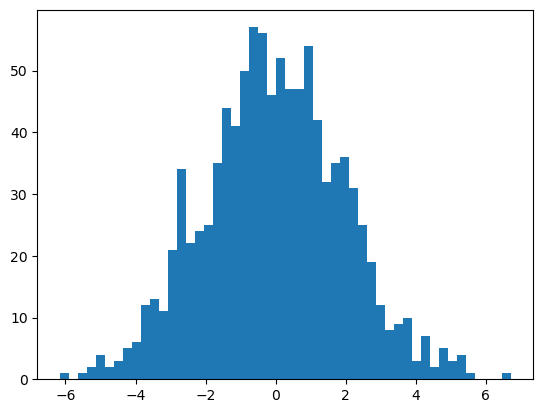

In [32]:
plt.hist(PnL, bins = 50)

In [33]:
print("P&L avg: " + str(np.mean(PnL)))
print("P&L std: " + str(np.std(PnL)))
print("P&L min: " + str(np.min(PnL)))
print("P&L max: " + str(np.max(PnL)))

P&L avg: -0.043924506142328255
P&L std: 1.9801699504732628
P&L min: -6.155416325784722
P&L max: 6.715971770235762


In [34]:
# compute P&L impacts and plot distribution
PnL_new = []
dBOs = []
dHedgingPtf_new = []

#hedging_strategy = hedging_ratios
hedging_strategy = new_hedging_ratios

delta_hedge = hedging_strategy[:len(stocks)]
vega_hedge = hedging_strategy[len(stocks):]

for i in range(nb_scenarios):
    shock = shocks[:,i]
    dS  = np.array(shock[:len(stocks)]) - np.array(stocks)
    dC = np.array(vanilla_options_shocks[i]) - np.array(vanilla_options)
    dBO = basket_options_shocks[i] - basket_option
    hedging_pnl = delta_hedge @ dS +vega_hedge @ dC
    
    dBOs.append(dBO)
    dHedgingPtf_new.append(hedging_pnl)
    
    pnl = hedging_pnl- dBO
    PnL_new.append(pnl)

(array([ 1.,  0.,  1.,  2.,  4.,  3.,  2.,  5.,  7., 11., 13., 12., 22.,
        32., 23., 23., 26., 37., 42., 41., 50., 58., 54., 46., 54., 46.,
        46., 55., 43., 30., 36., 36., 30., 28., 17., 12.,  7.,  9., 11.,
         3.,  6.,  4.,  3.,  3.,  4.,  1.,  0.,  0.,  0.,  1.]),
 array([-3.41255876, -3.26961215, -3.12666555, -2.98371894, -2.84077233,
        -2.69782573, -2.55487912, -2.41193251, -2.26898591, -2.1260393 ,
        -1.98309269, -1.84014609, -1.69719948, -1.55425287, -1.41130627,
        -1.26835966, -1.12541305, -0.98246645, -0.83951984, -0.69657323,
        -0.55362663, -0.41068002, -0.26773341, -0.12478681,  0.0181598 ,
         0.16110641,  0.30405301,  0.44699962,  0.58994623,  0.73289283,
         0.87583944,  1.01878604,  1.16173265,  1.30467926,  1.44762586,
         1.59057247,  1.73351908,  1.87646568,  2.01941229,  2.1623589 ,
         2.3053055 ,  2.44825211,  2.59119872,  2.73414532,  2.87709193,
         3.02003854,  3.16298514,  3.30593175,  3.44887836,

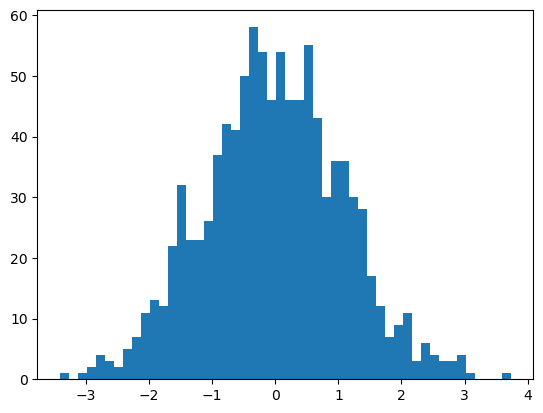

In [35]:
plt.hist(PnL_new, bins = 50)

In [331]:
print("P&L avg: " + str(np.mean(PnL_new)))
print("P&L std: " + str(np.std(PnL_new)))
print("P&L min: " + str(np.min(PnL_new)))
print("P&L max: " + str(np.max(PnL_new)))

P&L avg: -0.02451985712122189
P&L std: 1.1383304582461917
P&L min: -3.5491030173582265
P&L max: 3.807841198913718
